<a href="https://colab.research.google.com/github/oniviev/ml-intro-project-Nivievskyi/blob/main/LSTM_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@author: brign

import IPython
import IPython.display
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

In [6]:
# prompt: import data file from my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Assuming your data file is named 'your_data_file.csv' and located in 'My Drive/Data'
# Replace with your actual file path
file_path = '/content/drive/My Drive/data/LSTM - data.xlsx'
#file_path = '/content/drive/My Drive/data/prices sunflower 2000-2025.xlsx'
#df = pd.read_excel(file_path)

In [8]:
########################################## Load data ############################################################
# Read data
df = pd.read_excel(file_path)
n = len(df)

column_indices = {name: i for i, name in enumerate(df.columns)}
print(column_indices)

{'Corn': 0, 'Soybean': 1, 'HardW': 2, 'SoftW': 3, 'SP': 4, 'Nasdaq': 5, 'Gold': 6, 'WTI': 7, 'Dollar': 8, 'Milk': 9, 'Fcattle': 10, 'Lcattle': 11, 'Gasoline': 12}


In [9]:
########################################## Train and test split #################################################
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [10]:
########################################## Standardisation ######################################################
# train values are used across all datasets to not introduce informations which would not available to the model
#train_mean = train_df.mean()
#train_std = train_df.std()
#print(train_mean)
#print(train_std)
#train_df = (train_df - train_mean) / train_std
#val_df = (val_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std

num_features = df.shape[1]
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(num_features)

(3621, 13)
(1035, 13)
(518, 13)
13


In [11]:
########################################## Rolling Window approach - generation of data window ##################
# Define the class to then generate the windows
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Label column indices
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Window parameter
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift


    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  # To check dimensions
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
########################################## Rolling Window approach - generation of data window ##################
# Define the class to then generate the windows
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Label column indices
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Window parameter
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift


    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  # To check dimensions
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  # To plot the data and predictions
  def plot(self, model=None, plot_col='Corn', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [days]')

  @property
  def example(self):
    """Get a single example batch of inputs and labels."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was stored yet, so get one from the test dataset
      result = next(iter(self.test))
      # Store it for next time
      self._example = result
    return result

In [17]:
# Forecast horizon
OUT_STEPS = 30
w1 = WindowGenerator(input_width=365 , label_width=OUT_STEPS, shift= OUT_STEPS,
                     label_columns=['Corn'])
print(w1)

# To split original datasets into features and label windows of data
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# To create a tf.data.Dataset made of input and label windows
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=180,
      shuffle=False,
      batch_size=128)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

# To access the raw data from the tf.data.Dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

Total window size: 395
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [13]:
########################################## The model ############################################################
# Keep in mind that the hyperparameters need to be tuned, the one here represented should not
# be considered as optimal

# Number of training epochs
MAX_EPOCHS = 100

# To compile and fit the model
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adamax(learning_rate=0.0007187240050394409),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Building the model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]

     tf.keras.layers.LSTM(512, return_sequences = True,
                         kernel_regularizer=tf.keras.regularizers.l2(0.020750955184456563)),
     tf.keras.layers.LSTM(512, return_sequences = True,
                         kernel_regularizer=tf.keras.regularizers.l2(0.020750955184456563)),
     tf.keras.layers.LSTM(512, return_sequences = True,
                         kernel_regularizer=tf.keras.regularizers.l2(0.020750955184456563)),
     tf.keras.layers.LSTM(512, return_sequences = True,
                         kernel_regularizer=tf.keras.regularizers.l2(0.020750955184456563)),
     tf.keras.layers.LSTM(512, return_sequences = True,
                         kernel_regularizer=tf.keras.regularizers.l2(0.020750955184456563)),
     tf.keras.layers.LSTM(512, return_sequences = False,
                         kernel_regularizer=tf.keras.regularizers.l2(0.020750955184456563)),
#   # Shape => [batch, time, features]
     tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros),
     tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

# Compile and fit the model
history = compile_and_fit(lstm_model, w1)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - loss: 184533.5312 - mean_absolute_error: 393.4042 - val_loss: 128116.0391 - val_mean_absolute_error: 357.4555
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - loss: 184521.2969 - mean_absolute_error: 393.3936 - val_loss: 128044.6562 - val_mean_absolute_error: 357.3586
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - loss: 184427.1719 - mean_absolute_error: 393.2773 - val_loss: 127897.0547 - val_mean_absolute_error: 357.1536
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - loss: 184278.0469 - mean_absolute_error: 393.0884 - val_loss: 127753.7656 - val_mean_absolute_error: 356.9541
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - loss: 184125.2812 - mean_absolute_error: 392.8950 - val_loss: 127614.2500 - val_mean_absolute_error: 356.7597
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - loss: 183972.2969 - mean_absolute_error: 392.7012 - val_loss: 127463.5156 - val_mean_absolute_error: 356.5493
Epoch 7/100
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 104750.5547 - mean_absolute_error: 323.1747


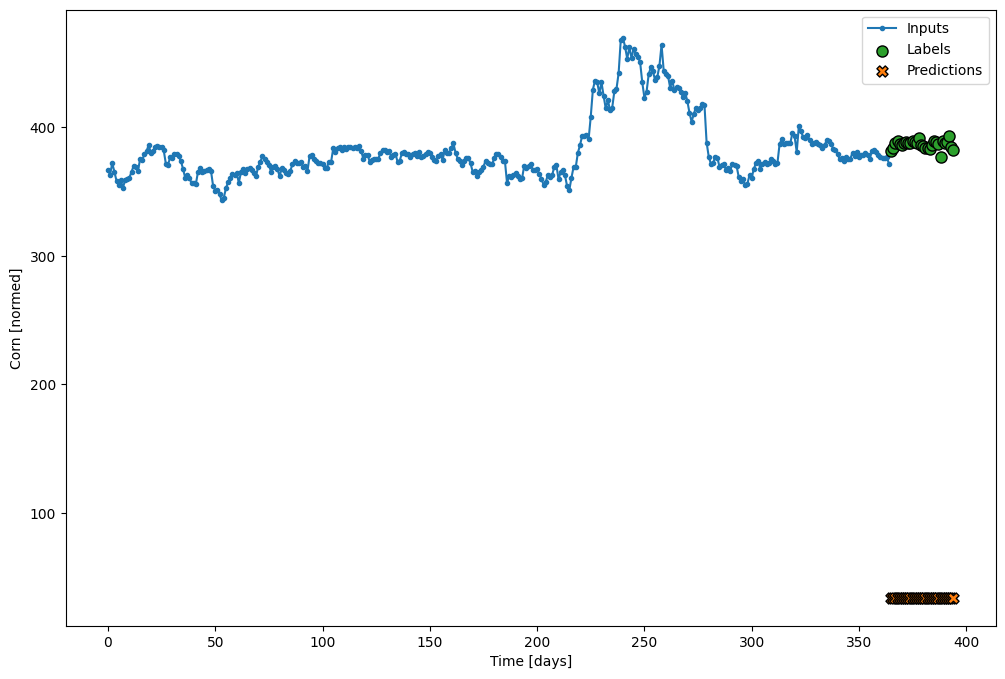

In [18]:
########################################## Evaluate model performances ##########################################
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['lstm_model'] = lstm_model.evaluate(w1.val)
performance['Dense'] = lstm_model.evaluate(w1.test, verbose=0)
w1.plot(lstm_model)



In [19]:

########################################## Predictions ##########################################################
print(history.history)
predictions = lstm_model.predict(w1.test)

########################################## References ###########################################################

{'loss': [184533.53125, 184521.296875, 184427.171875, 184278.046875, 184125.28125, 183972.296875, 183806.515625, 183618.421875, 183406.328125, 183175.09375, 182934.390625, 182692.96875, 182454.765625, 182219.578125, 181985.484375, 181750.34375, 181512.875, 181272.1875, 181028.0, 180780.328125, 180529.34375, 180275.25, 180018.3125, 179758.78125, 179496.796875, 179232.609375, 178966.4375, 178698.40625, 178428.765625, 178157.765625, 177885.578125, 177612.28125, 177338.109375, 177063.203125, 176787.53125, 176511.296875, 176234.578125, 175957.359375, 175679.78125, 175401.9375, 175123.828125, 174845.5, 174566.984375, 174288.421875, 174009.78125, 173731.03125, 173452.34375, 173173.65625, 172895.03125, 172616.4375, 172337.953125, 172059.578125, 171781.3125, 171503.21875, 171225.234375, 170947.453125, 170669.828125, 170392.359375, 170115.09375, 169838.046875, 169561.25, 169284.609375, 169008.1875, 168732.015625, 168456.109375, 168180.375, 167904.90625, 167629.671875, 167354.671875, 167079.95312